# Regression with an Abalone Dataset

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor

# Veriyi yükle
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# İlk 5 satırı göster
print(train.head())

# Temel istatistikler
print(train.describe())

# Eksik veri kontrolü
print(train.isnull().sum())

   id Sex  Length  Diameter  Height  Whole weight  Whole weight.1  \
0   0   F   0.550     0.430   0.150        0.7715          0.3285   
1   1   F   0.630     0.490   0.145        1.1300          0.4580   
2   2   I   0.160     0.110   0.025        0.0210          0.0055   
3   3   M   0.595     0.475   0.150        0.9145          0.3755   
4   4   I   0.555     0.425   0.130        0.7820          0.3695   

   Whole weight.2  Shell weight  Rings  
0          0.1465        0.2400     11  
1          0.2765        0.3200     11  
2          0.0030        0.0050      6  
3          0.2055        0.2500     10  
4          0.1600        0.1975      9  
                 id        Length      Diameter        Height  Whole weight  \
count  90615.000000  90615.000000  90615.000000  90615.000000  90615.000000   
mean   45307.000000      0.517098      0.401679      0.135464      0.789035   
std    26158.441658      0.118217      0.098026      0.038008      0.457671   
min        0.000000    

In [3]:
# 'Sex' sütununu sayısala dönüştür
train['Sex'] = train['Sex'].map({'M': 0, 'F': 1, 'I': 2})
test['Sex'] = test['Sex'].map({'M': 0, 'F': 1, 'I': 2})

In [4]:
# Hacim hesapla
train['Volume'] = train['Length'] * train['Diameter'] * train['Height']
test['Volume'] = test['Length'] * test['Diameter'] * test['Height']

# Ağırlık oranları
train['Shell_Weight_Ratio'] = train['Shell weight'] / train['Whole weight']
test['Shell_Weight_Ratio'] = test['Shell weight'] / test['Whole weight']

In [5]:
# Outlier'ları kırpma fonksiyonu
def clip_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df[column] = df[column].clip(lower_bound, upper_bound)

# Outlier temizleme
for col in ['Length', 'Diameter', 'Height', 'Whole weight']:
    clip_outliers(train, col)
    clip_outliers(test, col)

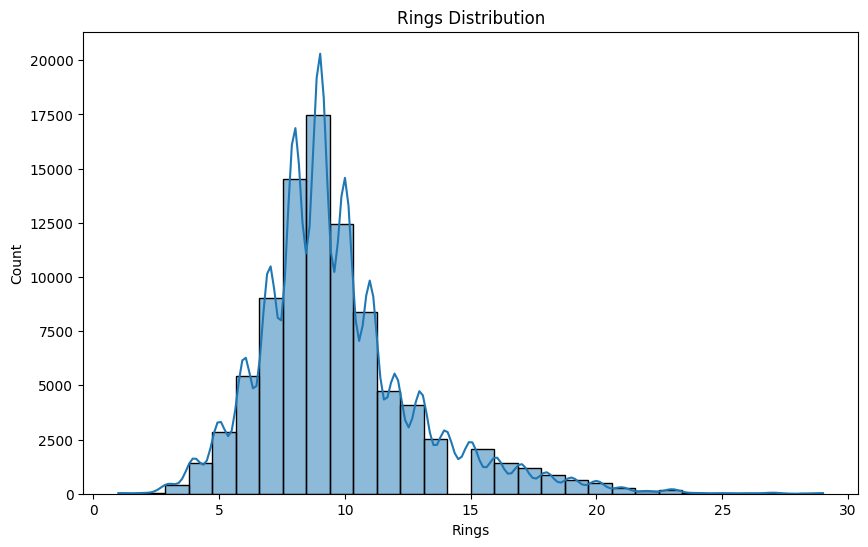

In [6]:
# 'Rings' dağılımı
plt.figure(figsize=(10, 6))
sns.histplot(train['Rings'], bins=30, kde=True)
plt.title('Rings Distribution')
plt.show()

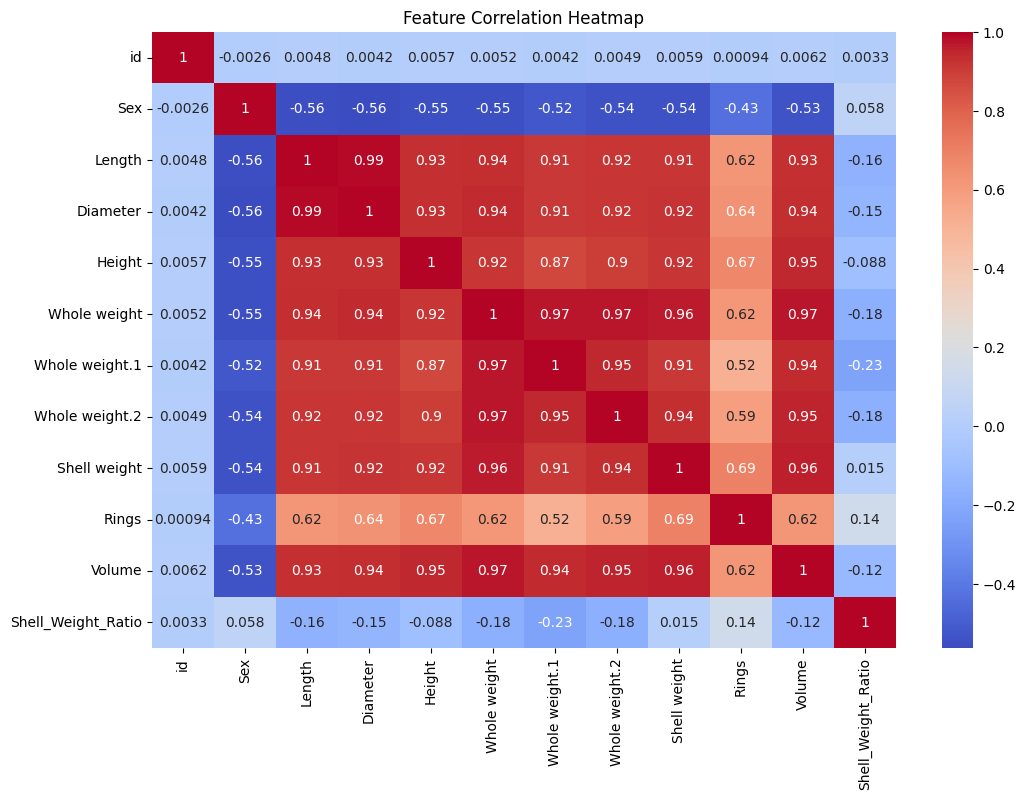

In [7]:
# Korelasyon matrisi
corr = train.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.show()

In [8]:
# Özellikler ve hedef değişken
X = train.drop(['id', 'Rings'], axis=1)
y = train['Rings']

# Train-test split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
# XGBoost modeli
xgb_model = XGBRegressor(n_estimators=1000, learning_rate=0.01, max_depth=5, random_state=42)
xgb_model.fit(X_train, y_train)

# Tahminler
xgb_preds = xgb_model.predict(X_val)

# RMSE hesapla
xgb_rmse = mean_squared_error(y_val, xgb_preds, squared=False)
print("XGBoost RMSE:", xgb_rmse)

XGBoost RMSE: 1.8844986085346602


C:\Users\BETÜL\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [10]:
# Random Forest modeli
rf_model = RandomForestRegressor(n_estimators=500, max_depth=10, random_state=42)
rf_model.fit(X_train, y_train)

# Tahminler
rf_preds = rf_model.predict(X_val)

# RMSE hesapla
rf_rmse = mean_squared_error(y_val, rf_preds, squared=False)
print("Random Forest RMSE:", rf_rmse)

Random Forest RMSE: 1.8956953376640626


C:\Users\BETÜL\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


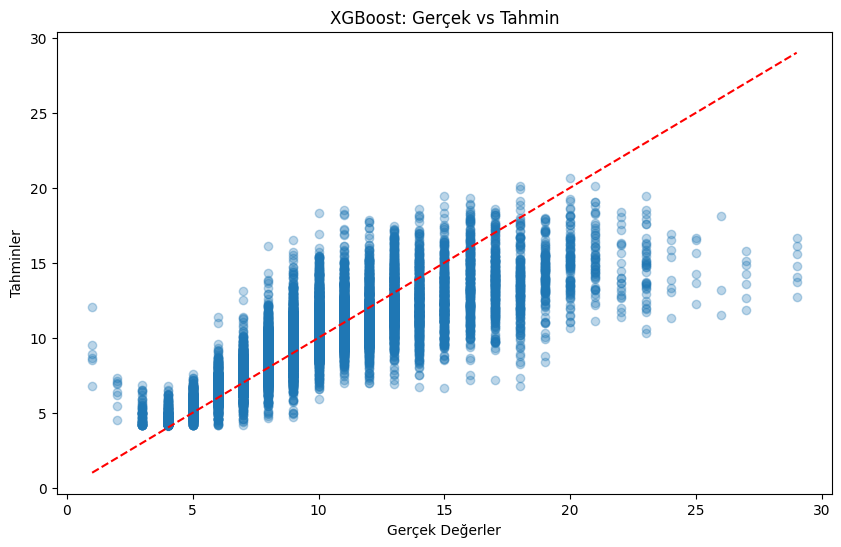

In [11]:
# XGBoost için gerçek vs tahmin
plt.figure(figsize=(10, 6))
plt.scatter(y_val, xgb_preds, alpha=0.3)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')
plt.xlabel('Gerçek Değerler')
plt.ylabel('Tahminler')
plt.title('XGBoost: Gerçek vs Tahmin')
plt.show()

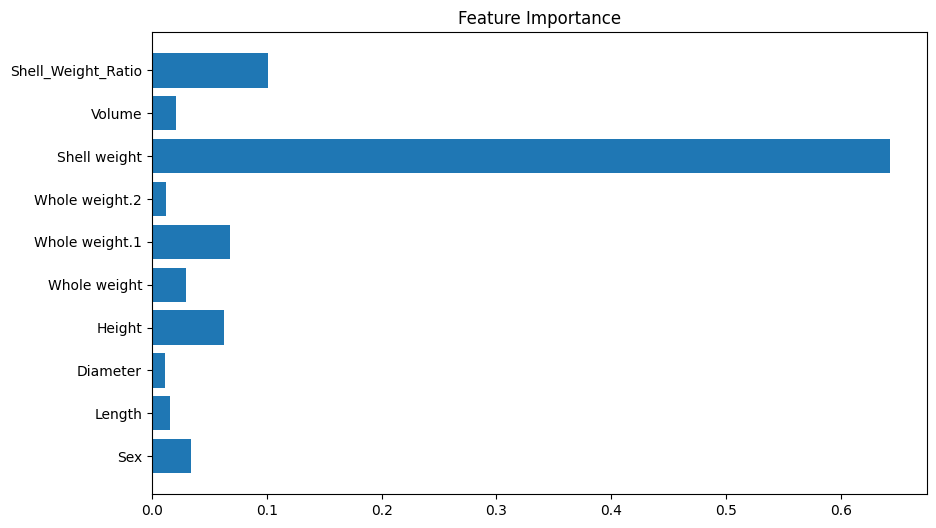

In [12]:
# XGBoost feature importance
importances = xgb_model.feature_importances_
feature_names = X_train.columns
plt.figure(figsize=(10, 6))
plt.barh(feature_names, importances)
plt.title('Feature Importance')
plt.show()

In [13]:
# Test seti üzerinde tahmin yap
test_preds = xgb_model.predict(test.drop('id', axis=1))

# Submission dosyası
submission = pd.DataFrame({'id': test['id'], 'Rings': test_preds})
submission.to_csv('abalone_submission.csv', index=False)